# Vyhodnocovanie a výber modelov strojového učenia

### Róbert Móro, Jakub Ševcech

IAU, 14.11.2019

## Spätnú väzbu nám môžete nechať tu: https://tinyurl.com/iau2019-w08

## Pýtať sa môžete na http://slido.com#iau2019-w08

# Opakovanie z minulej prednášky

## Komentár zo spätnej väzby: Zverejňujeme otázky zo skúšky alebo nie?

# Dnes sa pozrieme na to, ...

čo je to *kliatba dimenzionality*, a ako sa s ňou vieme vysporiadať

čo je strojové učenie, a ako delíme jeho rôzne prístupy

ako systematicky overovať/testovať modely strojového učenia a vyberať tie najlepšie

aké metriky vyhodnocovania sa používajú pri klasifikácii

čo sú bias a variancia, a ako vplývajú na modely strojového učenia

## Minule sme si ukázali, ako previesť text do vektorovej reprezentácie

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

tfidf_vect = TfidfVectorizer(stop_words='english')
X_train = tfidf_vect.fit_transform(twenty_train.data)
X_train.shape

(2257, 35482)

### Problém: Príliš veľa dimenzií

## Problém: Príliš veľa dimenzií

Vektory sú väčšinou veľmi riedke -> Potrebujeme toľko dimenzií? *Nevieme ich komprimovať?*

Kliatba dimenzionality - so zvyšujúcim sa počtom dimenzií sa zvyšuje objem priestoru; množstvo dát potrebné na rovnomerné pokrytie priestoru rastie exponenciálne

Viac ako 3 dimenzie nevieme vizualizovať

## Redukcia dimenzionality

Cieľom je zobraziť $n$-dimenzionálny priestor do $p$-dimenzionálneho, pričom $p < n$, ideálne $p \ll n$.

Chceme pritom prísť o čo najmenej informácií.

## Analýza hlavných komponentov (Prinicipal Component Analysis, PCA)

Cieľom je nájsť nové navzájom nekorelované súradnice, ktoré zachovávajú čo najviac variancie v pôvodných dátach.

<img src="img/basic-pca.png" alt="PCA" style="margin-left: auto; margin-right: auto; width:800px"/>

Zdroj: https://intoli.com/blog/pca-and-svd/

## PCA je založené na singulárnom rozklade matíc (singular value decomposition, SVD)

<img src="img/svd-matrices.png" alt="SVD" style="margin-left: auto; margin-right: auto; width:700px"/>

Zdroj: https://intoli.com/blog/pca-and-svd/

## PCA nad maticou dokumentov a slov = Latentná sémantická analýza (LSA)

Iný názov: Latentné sémantické indexovanie (LSI)

Využitie pri počítaní podobnosti dokumentov, podobnosti slov (latentné koncepty), vyhľadávaní dokumentov a pod.

Modernejšie (lepšie) reprezentácie sú *pLSA (pravdpodobnostná LSA)* alebo *LDA (Latentná Dirichletova alokácia)*.

Pozrite napr.: https://radimrehurek.com/gensim/tut2.html

## Dáta treba najskôr normalizovať

Ak majú jednotlivé črty veľmi odlišné stredné hodnoty a varianciu, tak tie s veľkou strednou hodnotou a varianciou budú nutne vstupovať s vačšou váhou bez ohľadu na ich výpovednú hodnotu.

Bez normalizácie váha atribútov neodráža ich dôležitosť, ale je spojená s ich škálovaním. Je to problém pri veľmi variabilných dátach s extrémnymi hodnotami.

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)

X_scaled = scaler.transform(X_train)

In [3]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(n_components=2)
principal = pca.fit_transform(X_scaled)

principal.shape

(2257, 2)

In [4]:
print(principal)

[[0.66968608 0.17719506]
 [0.37872068 0.30478467]
 [0.59864355 0.48792779]
 ...
 [0.47027943 0.32545522]
 [7.93337183 2.0675104 ]
 [0.1018375  0.0597561 ]]


In [5]:
pca.components_

array([[7.54601537e-04, 6.75603121e-04, 4.33519975e-04, ...,
        3.12243357e-06, 8.87925207e-06, 2.35417048e-05],
       [2.63631372e-04, 9.75630318e-04, 2.66992736e-04, ...,
        7.54755200e-07, 4.05397733e-06, 2.28024058e-05]])

In [6]:
pca.components_.shape

(2, 35482)

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def plot_pca(components, targets, labels):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Hlavný komponent 1', fontsize=15)
    ax.set_ylabel('Hlavný komponent 2', fontsize=15)
    ax.set_title('Redukcia do dvoch dimenzií pomocou PCA', fontsize=20)
    ax.set_ylim(ymax=2)
    ax.set_xlim(xmax=2)

    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    for target, color in zip(range(len(labels)), colors):
        ax.scatter(principal[targets == target, 0], principal[targets == target, 1],
                   c=color, s=50, label=labels[target])

    ax.legend()
    ax.grid()

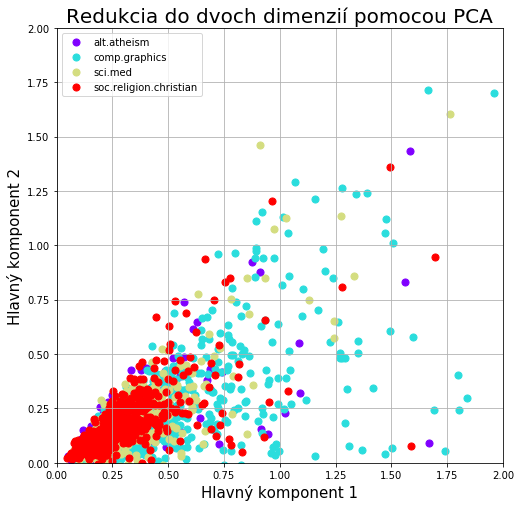

In [8]:
plot_pca(principal, twenty_train.target, twenty_train.target_names)

In [9]:
pca.explained_variance_ratio_

array([0.01720894, 0.01552945])

In [10]:
pca.explained_variance_ratio_.sum()

0.03273838545852819

In [11]:
pca1000 = TruncatedSVD(n_components=1000).fit(X_scaled)

(0, 1)

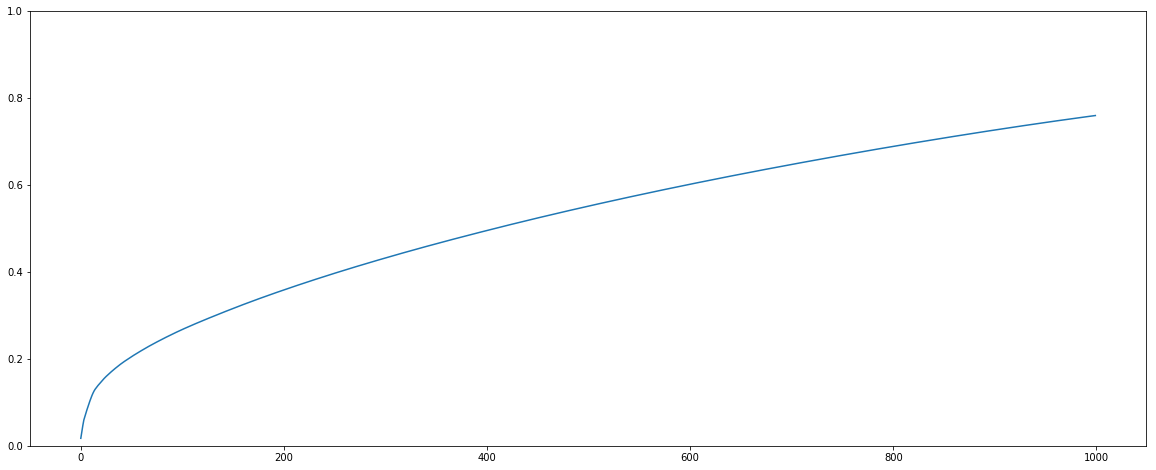

In [12]:
plt.figure(figsize=(20,8))
plt.plot(pca1000.explained_variance_ratio_.cumsum())
plt.ylim((0,1))

## Pozor: Redukcia dimenzionality $\neq$ výber atribútov (angl. feature selection)

# Biplot

Vizualizácia dát pomocou dvoch najvýznamnejších komponentov redukcie dimenzionality (PCA) spojená s vysvetlením dôležitosti atribútov reprezentovaných v týchto dvoch komponentoch.

Príklad adaptovaný z: https://github.com/teddyroland/python-biplot/blob/master/biplot.py

In [13]:
import seaborn
from sklearn import preprocessing

plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['font.family'] = 'DejaVu Sans'

In [14]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

In [15]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

t_X = scaler.transform(X)

In [17]:
from sklearn.decomposition import PCA

n = t_X.shape[1] # pocet stlpcov

pca = PCA(n_components = n)
pca.fit(t_X)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
xvector = pca.components_[0]
yvector = pca.components_[1]

xs = pca.transform(t_X)[:,0]
ys = pca.transform(t_X)[:,1]

In [19]:
color_map = {
    0: 'blue',
    1: 'green',
    2: 'red'
}

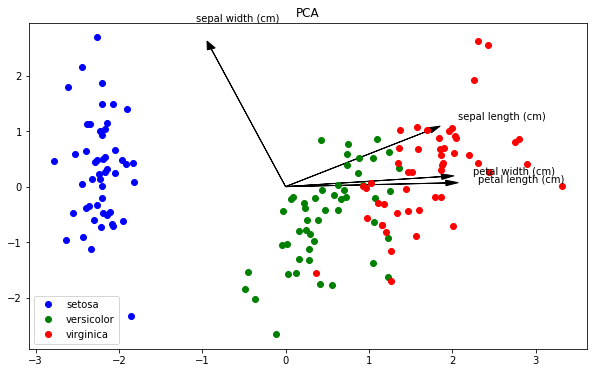

In [20]:
for i in range(len(xvector)):
# arrows project features (ie columns from csv) as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='black', width=0.0005, head_width=0.1)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             iris.feature_names[i], color='black')

for i in range(len(iris.target_names)):
    plt.plot(xs[y==i], ys[y==i], 'bo', color=color_map[i], label=iris.target_names[i])

plt.legend()
plt.title('PCA')
plt.show()

# Čo je to strojové účenie?

## Snažíme sa nájsť funkciu $f$ atribútov $X$, ktorá bude predikovať hodnotu závislej premennej $Y$

$$Y = f(X) + \epsilon$$

$Y$ – závislá premenná (response)

$X = (X_1, X_2, ..., X_p)$ – nezávislé premenné, črty, prediktory

$\epsilon$ – chyba (náhodný šum)

## $f$ nepoznáme, hľadáme jej aproximáciu $f’$

Chyba modelu: redukovateľná chyba

$\epsilon$ – neredukovateľná chyba

## Príklad: Cena bytu

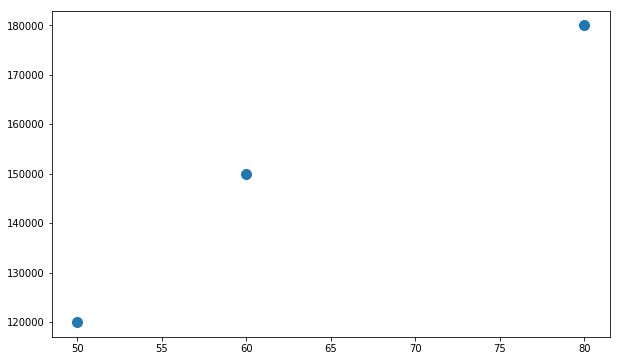

In [21]:
X = np.array([50, 60, 80]) # rozloha bytu v m2
y = np.array([120000, 150000, 180000]) # cena bytu

plt.scatter(X, y, s=100)

In [22]:
def flat_price(X):
    return 40000 + 1780*X

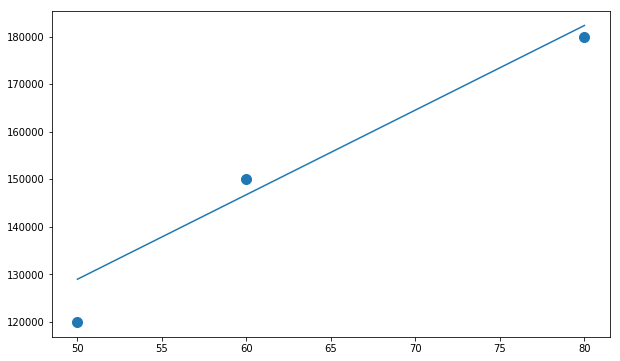

In [23]:
y_est = flat_price(X)

plt.scatter(X, y, s=100)
plt.plot(X, y_est)

## Existuje mnoho prístupov...

<img src="img/MachineLearningAlgorithms.png" alt="Machine Learning Algorithms" style="margin-left: auto; margin-right: auto; width:800px"/>

Zdroj: https://machinelearningmastery.com/a-tour-of-machine-learning-algorithms/

## Časté úlohy: Klasifikácia vs. regresia

### Klasifikácia
* Predikovaná premenná je kvalitatívna = kategorická (má množinu hodnôt)
* Napr. klasifikácia mailov spam/nie spam

### Regresia
* Predikovaná premenná je kvantitatívna = číselná (reálne číslo z intervalu)
* Napr. predikcia ceny bytov

## Učenie s učiteľom vs. učenie bez učiteľa

### S učiteľom (supervised learning)
Pri trénovaní modelu mám ohodnotené pozorovania (viem ich skutočnú hodnotu)

### Bez učiteľa (unsupervised learning)
Pozorovania nie sú ohodnotené. Hľadáme vzťahy, závislosti, zhluky, sekvencie, ...

## Parametrické vs. neparametrické prístupy

### Parametrické
Na začiatku si určíme formu (model) $f$, ktorý je opísaný konečným počtom parametrov (nezávisle od množstva dát). *Príklad: lineárna regresia, logistická regresia, Naivný Bayes.*

### Neparametrické
Formu $f$ dopredu neurčujeme, necháme ju naučiť sa z dát. *Príklad: algoritmus k-najbližsích susedov, rozhodovacie stromy, SVM*

## Generatívne vs. diskriminatívne (klasifikačné) prístupy

### Generatívne
Učíme sa distribúciu, ktorá vygenerovala dáta. *Napr.: Naivný Bayes*

### Diskriminatívne
Učíme sa hranicu, ktorá rozlíši dáta z rôznych tried. *Napr.: logistická regresia, rozhodovacie stromy, SVM*

## K dispozícii mám teda veľa prístupov, z ktorých môžem vyberať

Aj keď zvolím len jeden prístup, často má rôzne (hyper)parametre, ktoré môžem nastavovať

**Zásadný problém strojového učenia:** Ako vyberiem najlepší model? Resp. ako zistím, ako sa bude môj model správať na nových, doteraz nevidených dátach?

## Príklad: Dataset rakoviny prsníka

In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [25]:
plt.rcParams['figure.figsize'] = 9, 6

In [26]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

label_names = data['target_names']
labels = data['target']
feature_names = data['feature_names']
features = data['data']

In [27]:
label_names

array(['malignant', 'benign'], dtype='<U9')

In [28]:
labels[-10:]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1])

In [29]:
feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [30]:
df = pd.DataFrame(features)
df.columns = feature_names
df['target'] = labels
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [31]:
df.shape

(569, 31)

In [32]:
df.target.value_counts(normalize=True)

1    0.627417
0    0.372583
Name: target, dtype: float64

In [33]:
from sklearn.tree import DecisionTreeClassifier

cls = DecisionTreeClassifier()
model = cls.fit(features, labels)

cls.score(features, labels)

1.0

In [34]:
from sklearn.metrics import accuracy_score
preds = model.predict(features)
accuracy_score(labels, preds)

1.0

<img src="img/not-bad.jpg" alt="Not bad... Not bad at all!" style="margin-left: auto; margin-right: auto; width:400px"/>

<img src="img/the-end-or.jpg" alt="The end... Or is it?" style="margin-left: auto; margin-right: auto; width:1000px"/>

In [35]:
from sklearn.model_selection import train_test_split
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.33,
                                                          random_state=42)

In [36]:
cls = DecisionTreeClassifier(random_state=42)
model = cls.fit(train, train_labels)
preds = model.predict(test)

cls.score(train, train_labels)

1.0

In [37]:
cls.score(test, test_labels)

0.9202127659574468

In [38]:
accuracy_score(test_labels, preds)

0.9202127659574468

## Rozdelenie dát na trénovaciu a testovaciu vzorku: Základ trénovania a overovania modelov strojového učenia

Dáta delíme *náhodne* v nejakom pomere (napr. 70:30, 80:20, 90:10).

Výsledná správnosť modelu je na testovacej vzorke spravidla nižšia. Ak je rozdiel medzi správnosťou na trénovacej a testovacej vzorke veľký, došlo pravdepodobne k **pretrénovaniu**.

## Predstavme si nasledovnú situáciu...

Nátrenujem model, otestujem - úspešnosť 85%.

Nestačí mi, skúsim niečo na ňom zmeniť - opäť natrénujem, otestujem. Úspešnosť nového modelu (na testovacej vzorke) bude 86%.

*Ktorý model je lepší?*

## Leaderboard overfitting

http://blog.kaggle.com/2012/07/06/the-dangers-of-overfitting-psychopathy-post-mortem/

## Ako tomu predísť?

Rozdelenie na **trénovaciu - validačnú - testovaciu vzorku**. (Napr. 70:20:10)

Trénujem na trénovacej vzorke, overujem na validačnej. Vyberiem najlepší model na základe validačnej vzorky. 

Správnosť na testovacej vzorke - finálny odhad na nových (nevidených) dátach.

Dáta delíme náhodne - pri rôznych rozdeleniach budú rôzne výsledky.

Ak máme veľa dát, nebude to problém (rozdiely budú malé).

Ak máme málo dát - použijeme **krížovú validáciu**.

# Krížová validácia (cross-validation)

Väčšinou *k-násobná* (*k-fold*), kde k = 5 alebo 10.

* Rozdelíme dáta na *k* častí.
* *k – 1* častí použijeme na trénovanie, *k*-tu na testovanie
* Opakujeme *k*-krát.

Výsledný odhad chyby (správnosti) ako priemer z jednotlivých behov.

In [39]:
from sklearn.model_selection import cross_val_score

cls = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(cls, features, labels, cv=5)
print(scores)
print(scores.mean())

[0.91304348 0.90434783 0.92920354 0.95575221 0.88495575]
0.9174605617545211


{'boxes': [<matplotlib.lines.Line2D at 0x24d06cd9080>],
 'caps': [<matplotlib.lines.Line2D at 0x24d06cd9a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x24d06ce4748>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x24d06ce4320>],
 'whiskers': [<matplotlib.lines.Line2D at 0x24d06cd91d0>,
  <matplotlib.lines.Line2D at 0x24d06cd9668>]}

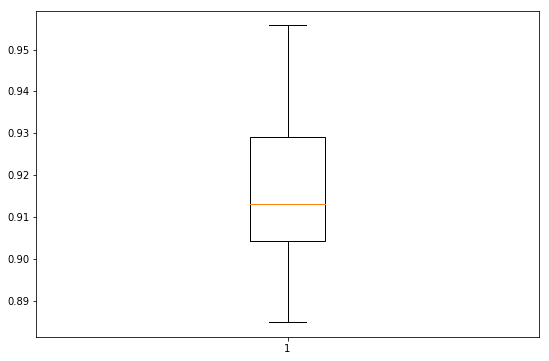

In [40]:
plt.boxplot(scores)

### Špeciálny prípad: Leave-One-Out krížová validácia

Trénujeme na n – 1 pozorovaniach, testujeme na zvyšnom pozorovaní.

In [41]:
%%time

from sklearn.model_selection import LeaveOneOut

cls = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(cls, features, labels, cv=LeaveOneOut())
print(scores)
print(scores.mean())

[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Krížová validácia vytvorí *k* modelov. Ako vybrať ten, ktorý sa použije v produkcii na predikciu?

**Nijak.** Používajte krížovú validáciu na nájdenie najlepšieho nastavenia (výber algoritmov, atribútov a hyperparametrov). Keď toto spravíte, natrénujte úplne nový model na všetkých dátach, ktoré máte a pustite to do produkcie.

Ak potrebujete odhadnúť, aká asi bude úspešnosť na neznámych dátach, otestujte takto natrénovaný model na samostatnej testovacej vzorke, ktorá nebola použitá pri trénovaní a validácii.

## Existujú aj ďalšie spôsoby, ako rozdeliť trénovacie a testovacie dáta

* Pri inkrementálnom spracovaní sa používa *Test-then-train* prístup, pri ktorom sa najskôr použijú dáta na overenie chyby modelu a potom sa použijú na upravenie modelu

* Ak máme závislosti medzi pozorovaniami (časové, generovanie spoločným procesom / používateľom), je možné upraviť rozdeľovanie tak, aby sa nachádzali závislé pozorovania spolu alebo aby boli rovnomerne rozdelené medzi jednotlivé sady

# Metriky vyhodnocovania

Existuje veľa rôznych metrík na vyhodnocovanie klasifikácie/regresie/zhlukovania... Veľa z nich je už predpripravených v SciKit knižnici.

http://scikit-learn.org/stable/modules/model_evaluation.html

Dnes sa budeme venovať hlavne klasifikácii, ale všetky tieto koncepty sú aplikovateľné aj pre iné úlohy analýzy dat, len s použitím zodpovedajucich metrik na vyhodnocovanie.

## Metriky vyhodnocovania: Klasifikácia

![classification metrics](img/metrics.png)

Zdroj obrazka: [https://en.wikipedia.org/wiki/Precision_and_recall](https://en.wikipedia.org/wiki/Precision_and_recall)

![confusion matrix](img/confusion_matrix2.png)

**Accuracy (správnosť)** - koľko pozorovaní bolo označných správne
$$accuracy = \frac{TP + TN}{ALL}$$

In [42]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_labels, preds)

array([[ 61,   6],
       [  9, 112]], dtype=int64)

In [43]:
accuracy_score(test_labels, preds)

0.9202127659574468

In [44]:
(61 + 112) / (61 + 6 + 9 + 112)

0.9202127659574468

## Obmedzenia metriky accuracy (správnosť)

In [45]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA


X, y = make_classification(n_classes=2, class_sep=1, weights=[0.95, 0.05],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=5000, random_state=10)

pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

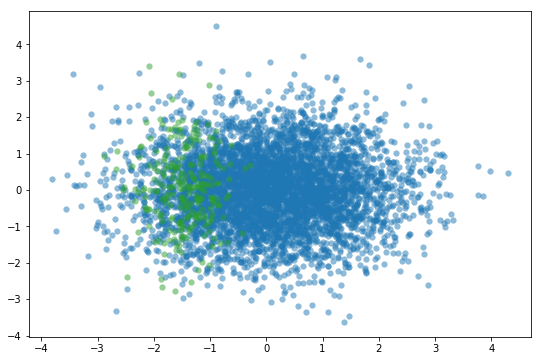

In [46]:
palette = seaborn.color_palette()

plt.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="Class #0", alpha=0.5,
            facecolor=palette[0], linewidth=0.15)
plt.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="Class #1", alpha=0.5,
            facecolor=palette[2], linewidth=0.15)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [48]:
from sklearn.neighbors import KNeighborsClassifier

cls = KNeighborsClassifier(3)
model = cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
accuracy_score(y_test, y_pred)

0.9586666666666667

In [49]:
accuracy_score(y_test, np.zeros(len(y_pred)))

0.952

**Precision (presnosť)** - koľko pozorovaní z tých, čo boli označené ako pozitívna trieda, má naozaj pozitívnu triedu
$$precision = \frac{TP}{TP + FP}$$

**Recall (úplnosť, pokrytie)** - koľko pozorovaní zo všetkých s pozitívnou triedou bolo označených ako pozitívna trieda
$$recall = \frac{TP}{TP + FN}$$

**F1 skóre**
$$F_1 = \frac{2PR}{P+R}$$

In [50]:
confusion_matrix(y_test, y_pred)

array([[1423,    5],
       [  57,   15]], dtype=int64)

In [51]:
from sklearn.metrics import precision_score

print(precision_score(y_test, y_pred))
print(precision_score(y_test, np.zeros(len(y_pred))))

0.75
0.0


C:\Users\robom\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
from sklearn.metrics import recall_score

print(recall_score(y_test, y_pred))
print(recall_score(y_test, np.zeros(len(y_pred))))

0.20833333333333334
0.0


In [53]:
from sklearn.metrics import f1_score

print(f1_score(y_test, y_pred))
print(f1_score(y_test, np.zeros(len(y_pred))))

0.32608695652173914
0.0


C:\Users\robom\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## V prípade predikcie do viacerých tried má zmysel ukázať výsledky pre jednotlivé triedy (niektoré metriky sa inak ani nedajú spočítať)

![multiclass confusion matrix](img/multi-class-confusionmatrix.png)

$$ precision_A = \frac{TP_A}{TP_A+FP_A} = \frac{TP_A}{TotalPredicted_A} = \frac{30}{60} = 0.5 $$

Úplnosť (recall) sa počíta obdobne

Ak chceme prezentovať jedno číslo, môžeme spočítať priemernú hodnotu. To, aké váhy sa priradia jednotlivým triedam, rozhoduje o vlastnostiach výsledneho čísla (pri nevyvážených datasetoch).

* Micro (globálne pre všetky triedy)
* Macro (nevážený priemer)
* Váhovaný priemer (na základe početnosti tried)

Ak máme nevyvážený dataset a zaujímajú nás aj triedy, ktoré sú málo početné, tak macro priemerovanie je veľmi užitočné.

In [54]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA


X, y = make_classification(n_classes=3, class_sep=2, weights=[0.9, 0.06, 0.04],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=5000, random_state=10)

pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

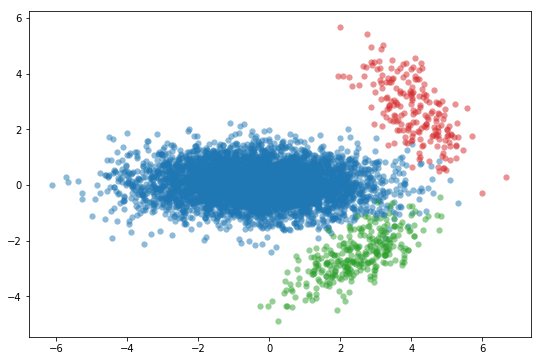

In [55]:
palette = seaborn.color_palette()

plt.scatter(X_vis[y == 0, 0], X_vis[y == 0, 1], label="Class #0", alpha=0.5,
            facecolor=palette[0], linewidth=0.15)
plt.scatter(X_vis[y == 1, 0], X_vis[y == 1, 1], label="Class #1", alpha=0.5,
            facecolor=palette[2], linewidth=0.15)
plt.scatter(X_vis[y == 2, 0], X_vis[y == 2, 1], label="Class #2", alpha=0.5,
            facecolor=palette[3], linewidth=0.15)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [57]:
from sklearn.neighbors import KNeighborsClassifier

cls = KNeighborsClassifier(3)
model = cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
accuracy_score(y_test, y_pred)

0.996

In [58]:
confusion_matrix(y_test, y_pred)

array([[1328,    0,    1],
       [   2,   97,    0],
       [   3,    0,   69]], dtype=int64)

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.99625   0.99925   0.99775      1329
           1    1.00000   0.97980   0.98980        99
           2    0.98571   0.95833   0.97183        72

   micro avg    0.99600   0.99600   0.99600      1500
   macro avg    0.99399   0.97913   0.98646      1500
weighted avg    0.99599   0.99600   0.99598      1500



In [60]:
print(precision_score(y_test, y_pred, average='weighted')) # pouziva sa vaha rovna poctu pozorovani per trieda
print(precision_score(y_test, y_pred, average='micro')) # pouziva sa globalny pocet TP, FN a FP
print(precision_score(y_test, y_pred, average='macro')) # spocita presnost pre kazdu triedu zvlast a spocita ich nevazeny priemer

0.9959909548815775
0.996
0.9939877826599508


In [61]:
print(precision_score(y_test, np.zeros(len(y_pred)), average='weighted'))
print(precision_score(y_test, np.zeros(len(y_pred)), average='micro'))
print(precision_score(y_test, np.zeros(len(y_pred)), average='macro'))

0.7849959999999999
0.886
0.29533333333333334


C:\Users\robom\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\robom\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## ROC krivka a plocha pod krivkou - Area Under ROC Curve (AUC)

Niektoré klasifikátory vracajú pravdepodobnosť, s ktoru pozorovanie patrí do zvolenej triedy.

Vieme nastaviť hranicu pre rozhodnutie (prednastavená 50%) - ovplyvníme tým počty správne/nesprávne zaklasifikovaných pozorovaní.

## ROC krivka a plocha pod krivkou - Area Under ROC Curve (AUC)

True positive rate (Sensitivity) a False positive rate (Specificity) sú navzájom prepojené. 
https://en.wikipedia.org/wiki/Sensitivity_and_specificity

Ak nastavujeme hraničnú pravdepodobnosť na zaradenie pozorovania do jednej triedy, meníme tým aj pravdepodobnosť zaradenia do druhej. Receiver Operating Characteristic (ROC) hovorí, ako navzájom súvisia. *Chceme, aby plocha pod touto krivkou (AUC) bola čo najvyššia.*

In [62]:
from scipy import interp
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc

iris = datasets.load_iris()
X = iris.data
y = iris.target

# klasicka ROC krivka sa pouziva len na binarnu klasifikaciu, budeme teda klasifikovat len jednu triedu
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Zasumime data, aby to vyzeralo krajsie
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

In [63]:
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
probabilities = classifier.fit(X_train, y_train).predict_proba(X_test) # chcem pravdepodobnosti zaradenia do tried

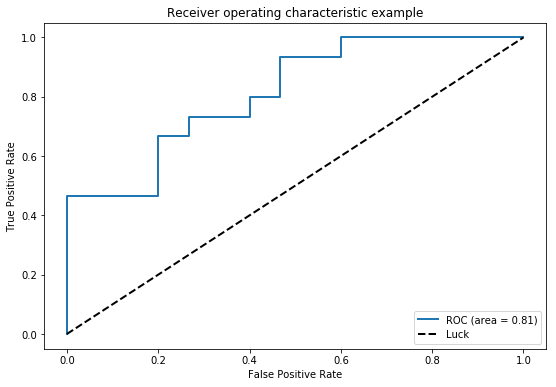

In [64]:
fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1]) # z pravdepodobnosti vypocitam body roc krivky
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=2, label='ROC (area = %0.2f)' % (roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', # nahodny klasifikator by spravil rovnu ciaru
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [65]:
from sklearn.metrics import roc_auc_score
probabilities = classifier.fit(X_train, y_train).predict_proba(X_test)
roc_auc_score(y_test, probabilities[:, 1])

0.8133333333333334

### Ak chceme upraviť ROC pre krížovú validáciu, môžeme si vykresliť krivky pre každý jej beh (angl. fold) ako aj priemernú krivku

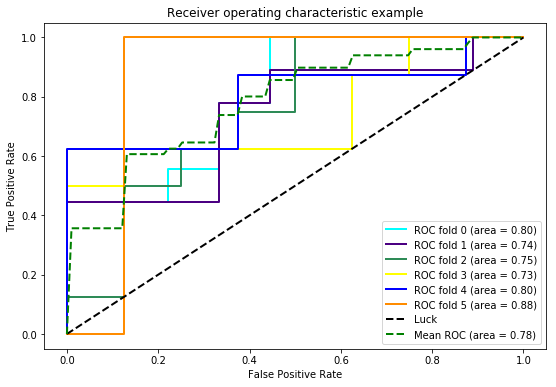

In [66]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=6)
# classifier = KNeighborsClassifier(3)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [67]:
# podobne aj pri cross validacii, ak ma nezaujimaju obrazky, tak je zapis jednoduchy
roc_auc_scores = cross_val_score(model, X, y, cv=6, scoring='roc_auc')
(roc_auc_scores.mean(), roc_auc_scores.std())

(0.6173964763374485, 0.15214305982630744)

### Podobne sa to dá použiť aj na ROC na viacerých triedach, aj keď to priamo na takýto prípad nie je určené

In [68]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
n_samples, n_features = X.shape

# Trosku zasumime tie data, aby to vyzeralo krajsie
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

In [69]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
transformed_target = lb.fit_transform(y)
# transformed_target[:,1]

In [70]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [71]:
transformed_target[:10]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, transformed_target, test_size=0.3, random_state=0)

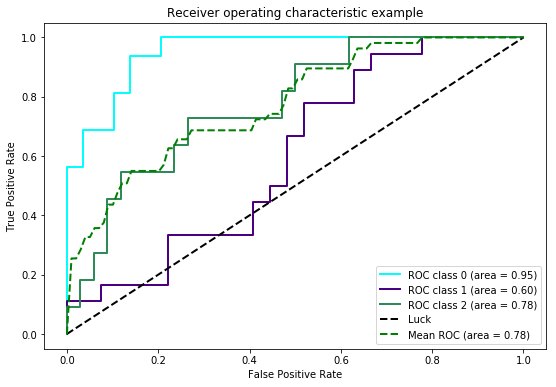

In [73]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
from sklearn.preprocessing import LabelBinarizer

# classifier = KNeighborsClassifier(3)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

lb = LabelBinarizer()
transformed_target = lb.fit_transform(iris.target)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])

for class_index, color in zip(range(len(lb.classes_)), colors):
    (train, test)
    probabilities = classifier.fit(X_train, y_train[:,class_index]).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test[:,class_index], probabilities[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC class %s (area = %0.2f)' % (lb.classes_[class_index], roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')

mean_tpr /= len(lb.classes_)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Koho by zaujímali ďalšie podrobnosti o vyhodnocovaní klasifikátorov a štatistické testy, perfektná prezentácia je tu:
http://www.icmla-conference.org/icmla10/CFP_Tutorial_files/jose.pdf

Podrobnejšie o ROC: http://cmp.felk.cvut.cz/~hlavac/TeachPresEn/31PattRecog/13ClassifierPerformance.pdf

### Existuje tiež Precison-recall curve, ktorá má podobné vlastnosti ako ROC, ale namiesto sensitivity a specificity sa používa precision a recall. V niektorých doménach sa táto používa častejšie.

## Úspešnosť modelu ako vzťah medzi biasom (skreslením) a varianciou

*Bias* je chyba spôsobená aproximáciou zložitého problému jednoduchším modelom.

*Variancia* nám hovorí, ako by sa zmenilo $f'$, ak by sme použili inú trénovaciu sadu.

## Bias (skreslenie) vs. variancia

<img src="img/bias-variance.png" alt="Bias vs. variancia" style="margin-left: auto; margin-right: auto; width:600px"/>

Zdroj: Domingos, Pedro. 2012. “A Few Useful Things to Know about Machine Learning.” Communications of the ACM 55 (10): 78. https://doi.org/10.1145/2347736.2347755.

## Podtrénovanie vs. pretrénovanie

![overfit](img/overfit.png)

* Ak máme veľmi veľký bias, znamená to, že máme nedotrénovany model (underfitting) a niečo nám v ňom chýba
* Ak máme veľkú varianciu, indikuje to, že sme model pretrénovali (overfitting)

Zdroj obrázku: https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted

## Celková chyba je zložená z variancie a biasu

Tieto dve chyby nevieme od seba oddeliť, ale snažíme sa nájsť bod, v ktorom sú v minime

![bias-variance](img/bias-variance2.png)

Zdroj: http://scott.fortmann-roe.com/docs/BiasVariance.html

## Snažíme sa nájsť takú zložitosť modelu, aby sme mali čo najmenšiu chybu na dátach, ktoré model nikdy nevidel

![validation error](img/validation-error.png)


Zdroj: http://puremonkey2010.blogspot.sk/2016/09/ml-bias-variance-and-overfitting.html

In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Rozdelíme údaje
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=4)

print('# train data: ', len(X_train))
print('# test data: ', len(X_test))

# train data:  455
# test data:  114


In [75]:
results = []
for i in range(1, X_train.shape[1] + 1):  
    row = {'model_complexity': i}
    # Vytvoríme rozhodovací strom
    clf = DecisionTreeClassifier(max_depth = i) # strom s maximalnou hlbkou 1-pocet atributov,  simulujeme tak zlozitost modelu
    
    pred = clf.fit(X_train, y_train).predict(X_train) # natrenovanie modelu a predikovanie na trenovacej sade
    row['train'] = 1-accuracy_score(y_train, pred) # chyba na trenovacej sade
    
    pred = clf.predict(X_test)
    row['test'] = 1-accuracy_score(y_test, pred) # chyba na testovacej sade
    results.append(row)

In [76]:
complexity_df = pd.DataFrame(results)
complexity_df.head()

,model_complexity,test,train
0,1,0.140351,0.065934
1,2,0.131579,0.052747
2,3,0.122807,0.021978
3,4,0.105263,0.017582
4,5,0.061404,0.008791


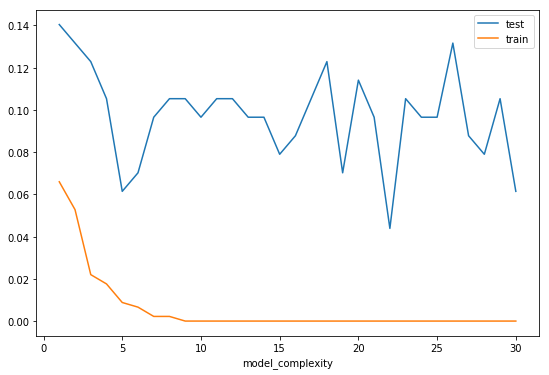

In [77]:
complexity_df.plot(x='model_complexity')

Ak sa už s rastúcou zložitosťou modelu nijak nezmenšuje chyba na trénovacej vzorke, je to indikátor toho, že sme model preučili. Naučil sa dáta, a nie vzťahy za nimi. Ak skúsime predikciu na iných dátach, narazíme na veľkú chybu spôsobenú varianciou.

## Varianciu a bias vieme kontrolovať množstvom dát

* pridáme trénovacie dáta
* pridáme ďalšie atribúty (zvýši sa tak zložitosť modelu)

## Čo si odniesť z dnešnej prednášky

Ak chceme vyhodnotiť modely strojového učenia, potrebujeme:
* vhodné metriky
* vhodnú metodológiu testovania/overovania

Snaha vybrať najlepší model a zabrániť **preučeniu**.

## Spätnú väzbu nám môžete nechať tu: https://tinyurl.com/iau2019-w08